## Compare fits and covariance structure of 3 parameter fit and Gaussian Process (Gibbs kernel with 3 parameter fit function mean) on the 13 TeV data set and on a smooth data set. Smooth data set is 5 parameter fit to 13 TeV data set with Poisson errors

In [3]:
%pylab inline --no-import-all
import george
from george.kernels import MyDijetKernelSimp


import math
import time
import numpy as np
import scipy.stats as ss
import scipy.special as ssp
import scipy.optimize as op
from iminuit import Minuit
import emcee

import ROOT as r
from rootpy.plotting import Hist, Hist2D, Legend, Canvas
import rootpy.plotting.root2matplotlib as rplt

Populating the interactive namespace from numpy and matplotlib


#### Load data set

In [173]:
xvalO = np.load("newoutputs/xvalO.npy")
yvalO = np.load("newoutputs/yvalO.npy")
xerrO = np.load("newoutputs/xerrO.npy")
xlowO = np.load("newoutputs/xlowO.npy")
xval = np.load("newoutputs/xval.npy")
yval = np.load("newoutputs/yval.npy")
xerr = np.load("newoutputs/xerr.npy")


xvalO2D = xvalO.reshape(-1,1)
yvalO2D = yvalO.reshape(-1,1)

#### Function to draw correlation matrix, log of covaraince matrix, and covariance matrix
#### Draw correlation and covariance matrix as a function of mjj

In [5]:
def plot_cov(X, C, K, stationary=True):
    K = K #+ 1e-8*np.eye(X.shape[0])
    x = X.flatten()
    
    fig = plt.figure(figsize=(14,5))
    ax1 = fig.add_subplot(131)
    m = ax1.imshow(C, cmap="inferno",
                   interpolation='none',
                   extent=(np.min(X), np.max(X), np.max(X), np.min(X)));
    plt.colorbar(m);
    ax1.set_title("Correlation Matrix")
    ax1.set_xlabel("X")
    ax1.set_ylabel("X")

    ax2 = fig.add_subplot(132)
    m = ax2.imshow(np.log(K), cmap="inferno",
                   interpolation='none',
                   extent=(np.min(X), np.max(X), np.max(X), np.min(X)));
    plt.colorbar(m);
    ax2.set_title("Log(Covariance Matrix)")
    ax2.set_xlabel("X")
    ax2.set_ylabel("X")
    
    ax3 = fig.add_subplot(133)
    m = ax3.imshow(K, cmap="inferno",
                   interpolation='none',
                   extent=(np.min(X), np.max(X), np.max(X), np.min(X)));
    plt.colorbar(m);
    ax3.set_title("Covariance Matrix")
    ax3.set_xlabel("X")
    ax3.set_ylabel("X")
    
    fig = plt.figure(figsize=(13,5))
    ax = fig.add_subplot(111)
    if not stationary:
        ax.plot(x, np.diag(K), "k", lw=2, alpha=0.8)
        ax.set_title("The Diagonal of K")
        ax.set_ylabel("k(x,x)")
        ax.set_xscale('log')
        ax.set_yscale('log')
    else:
        ax.plot(x, K[:,0], "k", lw=2, alpha=0.8)
        ax.set_title("K as a function of x - x'")
        ax.set_ylabel("k(x,x')")
    ax.set_xlabel("X")

def plot_cor(X, C, stationary=True):
    #K = K #+ 1e-8*np.eye(X.shape[0])
    x = X.flatten()
    fig = plt.figure(figsize=(6,5))
    m = plt.imshow(C, cmap="bwr",
                   interpolation='none',
                   vmin=-1, vmax=1,
                   aspect='auto',
                   extent=(np.min(X), np.max(X), np.max(X), np.min(X)));
    cbar = plt.colorbar(m)
    m.set_clim(vmin=-1, vmax=1)
    cbar.ax.tick_params(labelsize=20) 
    plt.title("Correlation Matrix", fontsize=20)
    plt.xlabel("Mass [TeV]", fontsize=20)
    plt.ylabel("Mass [TeV]", fontsize=20)
    plt.tick_params(axis='y', labelsize=20)
    plt.tick_params(axis='x', labelsize=20)
    labels = ["2","3","4","5","6","7"]
    plt.xticks([2000, 3000, 4000, 5000, 6000, 7000], labels)
    plt.yticks([2000, 3000, 4000, 5000, 6000, 7000], labels)

def plot_individualCov(C, K):
    fig = plt.figure(figsize=(14,5))
    ax1 = fig.add_subplot(131)
    for i in range(len(K[1])):
        ax1.plot(xvalO,(K[i,:]))
    ax1.semilogy()
    ax1.set_title("Covariance vs mjj")
    
    ax2 = fig.add_subplot(132)
    ax2.semilogy()
    for i in range(len(C[1])):
        plt.plot(xvalO,C[i,:])
    ax2.set_title("Correlation vs mjj")
    
    ax3 = fig.add_subplot(133)
    ax3.plot(xvalO,(K[5,:]), c='r', label="Covariance for bin 5")
    ax3.plot(xvalO,(K[40,:]), c='g', label="Covariance for bin 40")
    ax3.plot(xvalO,(K[75,:]),c='b', label = "Covariance for bin 75")
    ax3.legend()
    ax3.semilogy()

#### Function to calculate sigificances (shown in bottom panel of plots)

In [6]:
def calcSignificance(Data, Bkg):
    pvals = []
    zvals = []
    chi2 = 0
    for i, nD in enumerate(Data):
        nB = Bkg[i]
        if nD != 0:
            if nB > nD:
                pval = 1.-ssp.gammainc(nD+1.,nB)
            else:
                pval = ssp.gammainc(nD,nB)
            prob = 1.-2.*pval
            if prob > -1 and prob < 1:
                zval = math.sqrt(2.)*ssp.erfinv(prob)
            else:
                zval = np.inf
            if zval > 100: zval = 20
            if zval < 0: zval = 0
            if (nD < nB): zval = -zval
        else: zval = 0
            
        zvals.append(zval)
        chi2 += ((nD - nB) ** 2 / abs(nB))
    return zvals, chi2

#### Function to draw fit overlaid on data on top panel, residuals on bottom panel

In [7]:
def makePrettyPlots(xs, ys, bkgs, title, col = 'g', ymax = 2e5):
    f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12,12), gridspec_kw = {'height_ratios':[3, 1]})
    f.suptitle(title, fontsize=30)
    dataPlot = ax1.errorbar(xs, ys, marker='o', ls='None', yerr = np.sqrt(ys), c='black', markersize=10, label="data+signal")
    bkgPlot, =ax1.plot(xs, bkgs, color=col, linewidth=3.0, label="bkg only")
    ax1.legend()
    ax1.set_ylabel('Events', fontsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 7500])
    ax1.set_ylim([0.01, ymax])

   
    zvals, chi2 = calcSignificance(ys, bkgs)
    h1 = Hist(list(xlowO),markersize=0)
    for x in range(len(zvals)):
        if zvals[x] == np.inf or zvals[x] == -np.inf: h1[x] = 20
        else: h1[x] = zvals[x]  
    
    h1.fillstyle = 'solid'
    if col == 'g':
         h1.fillcolor = 'green'
    elif col == 'b':
         h1.fillcolor = 'blue'
    elif col == 'r':
         h1.fillcolor = 'red'
    else:
        h1.fillcolor = 'black'
    h1.linecolor = 'black'
    h1.linewidth = 1
    h1.Draw("histX0")
    rplt.bar(h1, xerr=None, yerr=None)
    ax2.axhline(0, color='black', lw=1)
    ax2.tick_params(axis='x', labelsize=20)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=30)
    ax2.set_ylabel('Significance', fontsize=20)
    ax2.set_xscale('log')
    ax2.set_xlim([1000, 7500])
    ax2.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    minor_ticks = np.arange(1000, 7500, 100)
    ax2.set_xticks(minor_ticks, minor=True)  
    labels = ["1","2","3","4","5","6","7"]
    ax2.set_xticklabels(labels)
    ax2.set_ylim([-5, 5])
    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)    
    plt.show()



In [8]:
def makePrettyPlots_bkgFits(xs, ys, bkgFits, title, ymax = 2e5):
    f, ax1 = plt.subplots(1, sharex=True, figsize=(12,12))
    f.suptitle(title, fontsize=30)
    dataPlot = ax1.errorbar(xs, ys, marker='o', ls='None', yerr = np.sqrt(ys), c='black', markersize=10, label="data+signal")
    for ik, bkg in enumerate(bkgFits):
        if ik == 0:
            bkgPlot, =ax1.plot(xs, bkg, color="b", alpha=0.3, linewidth=1.0, label="3 param only fit")
        else:
            bkgPlot, =ax1.plot(xs, bkg, color="b", alpha=0.3, linewidth=1.0)
    ax1.legend()
    ax1.set_ylabel('Events', fontsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 7500])
    ax1.set_ylim([0.01, ymax])


    ax1.tick_params(axis='x', labelsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=30)

    ax1.set_xlim([1000, 7500])
    ax1.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    minor_ticks = np.arange(1000, 7500, 100)
    ax1.set_xticks(minor_ticks, minor=True)  
    labels = ["1","2","3","4","5","6","7"]
    ax1.set_xticklabels(labels)
    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)    
    plt.show()

#### Minuit minimization of Gaussian Process likelihood
* 3 parameter function to use as mean in GP
* log likelihood of GP from george
* minuit minimze log likelihood of GP

In [9]:
def model_gp(params, t, xerr=xerr): 
    p0, p1, p2 = params
    sqrts = 13000.
    return (p0 * (1.-t/sqrts)**p1 * (t/sqrts)**(p2))*xerr


class logLike_gp_minuit:
    def __init__(self, x, y, xerr):
        self.x = x
        self.y = y
        self.xerr = xerr
    def __call__(self, Amp, decay, length, power, sub, p0, p1, p2):
        kernel = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d = sub)
        gp = george.GP(kernel)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            return -gp.lnlikelihood(self.y - model_gp((p0,p1,p2), self.x, self.xerr))
        except:
            return np.inf
        
        
def fit_gp_minuit(lnprob, Print = True):
    minLLH = np.inf
    best_fit_params = (0, 0, 0, 0, 0, 0, 0, 0)
    for num in range(100):
        init0 = np.random.random() * 1e7+1
        init1 = np.random.random() * 200.
        init2 = np.random.random() * 10. 
        init3 = np.random.random() * -100.
        init4 = np.random.random() * 6.
        init5 = np.random.random() * 1.
        init6 = np.random.random() * 1.
        init7 = np.random.random() * -1.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  Amp = init0, decay = init1, length = init2, power = init3, sub = init4, 
                   p0 = init5, p1 = init6, p2 = init7,
                  error_Amp = 1e1, error_decay = 1e1, error_length = 1e-1, error_power = 1e-1, 
                   error_sub = 1e-1, error_p0 = 1e-2, error_p1 = 1e-2, error_p2 = 1e-2,
                  limit_Amp = (1, 1e15), limit_decay = (0, 500), limit_length = (0, 200), 
                   limit_power = (-200, 200), limit_sub = (0, 100), limit_p0 = (0, 10),
                   limit_p1 = (0, 20), limit_p2 = (-10,10)) 
        fit = m.migrad()

        if m.fval < minLLH:
            minLLH = m.fval
            best_fit_params = m.args     
    if Print:
        print "min LL",minLLH
        print "best fit vals", best_fit_params
    return minLLH, best_fit_params

In [14]:
def makePrettyPlots_errorBars(xs, ys, gpFits, errorFit, title, ymax = 2e5):
    f, ax1 = plt.subplots(1, sharex=True, figsize=(12,12))
    f.suptitle(title, fontsize=40)
    dataPlot = ax1.errorbar(xs, ys, marker='o', ls='None', yerr = np.sqrt(ys), c='black', markersize=10, label="ATLAS data")
    
    ax1.fill_between(xs, gpFits-errorFit, gpFits+errorFit, facecolor='g', alpha=0.5, label="Gaussian Process")
    ax1.plot(xs, gpFits, c='green', lw=2)
    
    ax1.legend(prop={'size':20})
    ax1.set_ylabel('Events per bin', fontsize=40)
    ax1.tick_params(axis='y', labelsize=30)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 7500])
    ax1.set_ylim([0.01, ymax])


    ax1.tick_params(axis='x', labelsize=30)
    ax1.tick_params(axis='y', labelsize=30)
    ax1.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=40)

    ax1.set_xlim([1000, 7500])
    ax1.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    minor_ticks = np.arange(1000, 7500, 100)
    ax1.set_xticks(minor_ticks, minor=True)  
    labels = ["1","2","3","4","5","6","7"]
    ax1.set_xticklabels(labels)
    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)    
    plt.show()

### GP fit on atlas data
* return minimum log likelihood, parameter values that correspond to minimum likelihood, and mean and covaraince of predictive distribution 
* use 3 parameter fit function as mean, fit mean parameters and kernel parameters

In [34]:
lnProb = logLike_gp_minuit(xval,yval, xerr)
minimumLLH, best_fit_hyperparams = fit_gp_minuit(lnProb)
Amp, decay, length, power, sub, p0, p1, p2 = best_fit_hyperparams
kernel = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)
gp = george.GP(kernel)
gp.compute(xval, np.sqrt(yval))
meanGPp, covGP = gp.predict(yval - model_gp(best_fit_hyperparams[5:],xval, xerr), xvalO)
meanGP = meanGPp + model_gp(best_fit_hyperparams[5:],xvalO,xerrO)

min LL 310.526381775
best fit vals (15564887.490793113, 170.801745025563, 0.11588276382242801, -128.9068871442665, 27.394368949578396, 0.016608125192957846, 8.461568217855739, -5.222561309950205)


In [35]:
print np.sqrt(np.diag(covGP))

[  1.39392557e+02   1.26807163e+02   1.15519532e+02   1.04823936e+02
   9.50269106e+01   8.57974514e+01   7.68374399e+01   6.87746891e+01
   6.13805233e+01   5.46534563e+01   4.87383221e+01   4.34365429e+01
   3.86667439e+01   3.44062915e+01   3.05434934e+01   2.70849634e+01
   2.40159847e+01   2.12581323e+01   1.87689793e+01   1.65509241e+01
   1.45809112e+01   1.28113390e+01   1.12210808e+01   9.79595987e+00
   8.53721678e+00   7.42864040e+00   6.44467604e+00   5.57326475e+00
   4.80340989e+00   4.12568653e+00   3.53168941e+00   3.01333753e+00
   2.56275595e+00   2.17248700e+00   1.83564869e+00   1.54597638e+00
   1.29779389e+00   1.08595632e+00   9.05806157e-01   7.53153404e-01
   6.24259846e-01   5.15812852e-01   4.24890655e-01   3.48926626e-01
   2.85259579e-01   2.32168344e-01   1.88391804e-01   1.52412741e-01
   1.22757812e-01   9.84347421e-02   7.86968645e-02   6.27306383e-02
   4.97832309e-02   3.93341915e-02   3.09869538e-02   2.43038589e-02
   1.89784406e-02   1.47548806e-02

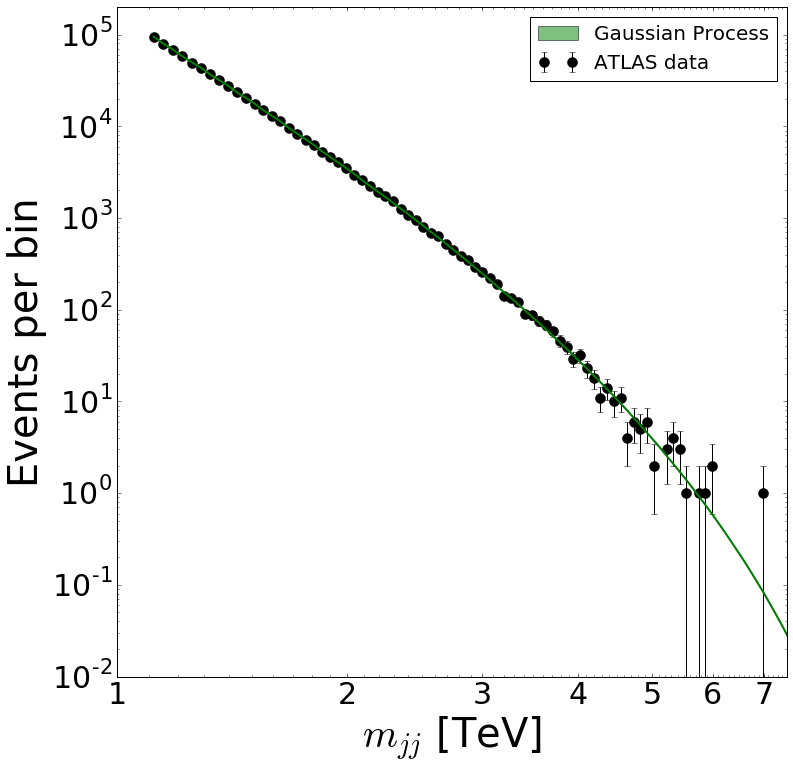

In [36]:
makePrettyPlots_errorBars(xvalO, yvalO, meanGP, np.sqrt(np.diag(covGP)), "")

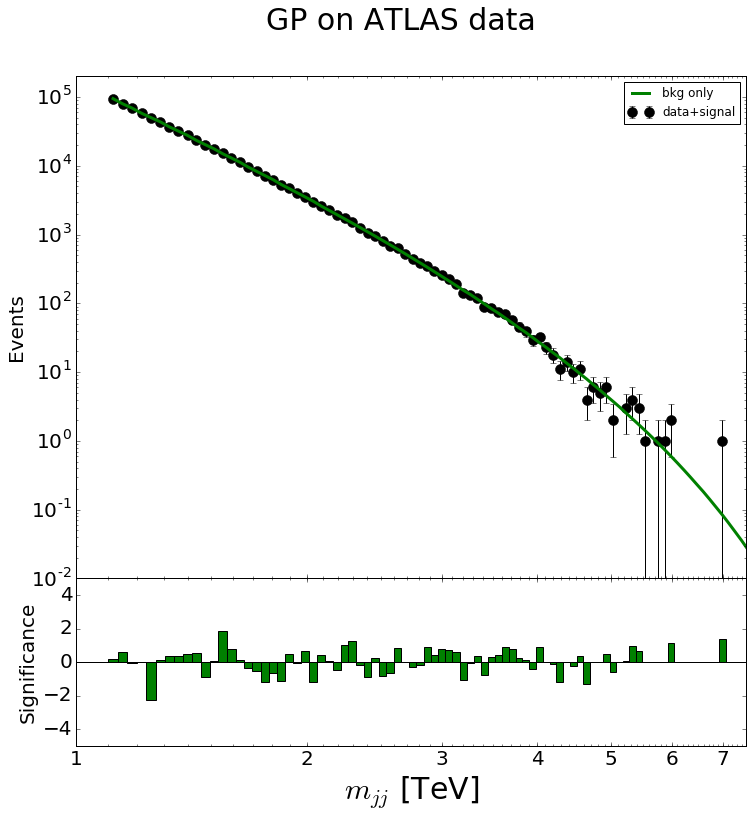

In [37]:
makePrettyPlots(xvalO, yvalO, meanGP, "GP on ATLAS data")

#### sample posterior, create covariance matrix

In [38]:
samps = gp.sample_conditional(yval - model_gp(best_fit_hyperparams[5:],xval, xerr), xvalO, 1000)
print samps.shape
modelMatrix=np.empty([samps.shape[0], xvalO.size])
print modelMatrix.shape
for ip, ps in enumerate(samps):
    modelMatrix[ip,:]= samps[ip,:]+ model_gp(best_fit_hyperparams[5:],xvalO, xerrO)
covMat = np.cov(modelMatrix.T)
corMat = np.corrcoef(modelMatrix.T)

(1000, 90)
(1000, 90)


[  9.48585726e+04   7.93697540e+04   6.88240309e+04   5.79944090e+04
   5.01332885e+04   4.34643233e+04   3.65811693e+04   3.18687608e+04
   2.76985554e+04   2.34108330e+04   2.03939751e+04   1.77284172e+04
   1.50256286e+04   1.30453528e+04   1.12976826e+04   9.56571192e+03
   8.30409937e+03   7.21082538e+03   6.26555454e+03   5.33295641e+03
   4.64751615e+03   4.04759704e+03   3.52164294e+03   3.05888430e+03
   2.60337130e+03   2.26170349e+03   1.96192922e+03   1.69885660e+03
   1.46920216e+03   1.27042881e+03   1.09900172e+03   9.50787028e+02
   8.22068577e+02   7.09935449e+02   6.12201786e+02   5.27190766e+02
   4.53498192e+02   3.89824222e+02   3.34939248e+02   2.87711664e+02
   2.47106837e+02   2.12176154e+02   1.82077026e+02   1.56102616e+02
   1.35449691e+02   1.15559403e+02   9.84959649e+01   8.38857962e+01
   7.22738833e+01   6.13201702e+01   5.19934921e+01   4.40516841e+01
   3.77181488e+01   3.18204769e+01   2.68187785e+01   2.28272363e+01
   1.91558557e+01   1.62276189e+01

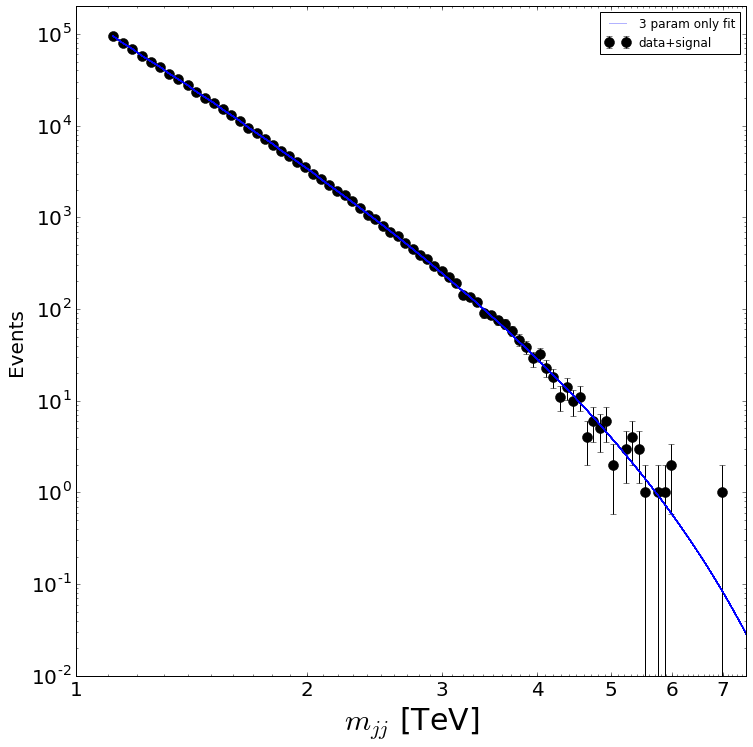

[  1.18367667e+02  -1.08555641e+02   1.34621306e+01   7.83865365e+01
  -1.25160512e+02  -7.48937320e+01  -1.46688350e+02  -2.18412250e+01
   5.00912548e+01   3.62077640e+01   8.34330722e+01   1.04550084e+02
   9.43281343e+01   6.14467544e+01   2.14782801e+01  -6.87227364e+00
  -2.62775808e+01  -2.99511681e+01  -2.11627970e+01  -1.07538187e+01
  -1.09246707e+00   7.97465007e+00   1.47573001e+01   1.73803509e+01
   1.63566634e+01   1.39047344e+01   1.07156352e+01   6.63185613e+00
   2.87049368e+00   9.05634131e-01   7.67703363e-01   1.48375932e+00
   2.13375829e+00   2.27496556e+00   1.89607978e+00   1.23275113e+00
   5.60024689e-01   5.02929236e-02  -2.37100874e-01  -3.06738353e-01
  -2.08996355e-01  -3.38824901e-02   1.24224661e-01   2.09852469e-01
   2.18941170e-01   1.78978122e-01   1.24474251e-01   7.93809637e-02
   5.31280791e-02   4.40699350e-02   4.43326322e-02   4.58734083e-02
   4.43806215e-02   3.93933242e-02   3.25033899e-02   2.53986013e-02
   1.90947575e-02   1.39206903e-02

In [44]:
print modelMatrix[0]
print modelMatrix[-1]
makePrettyPlots_bkgFits(xvalO, yvalO, (modelMatrix[:100]).tolist(), "", ymax = 2e5)
print samps[0]
print samps[-1]

/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in log


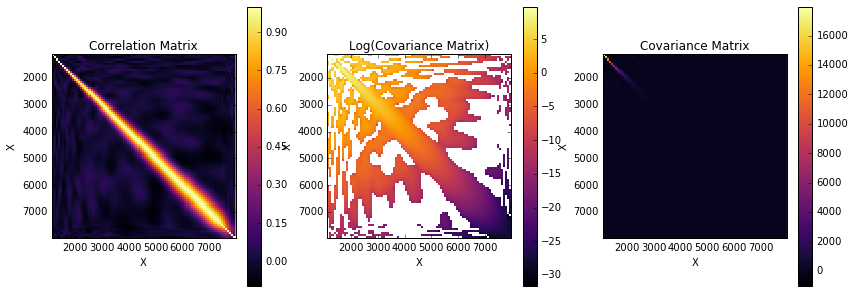

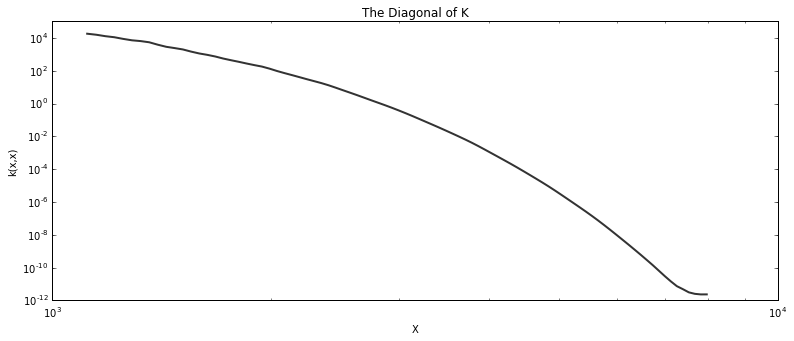

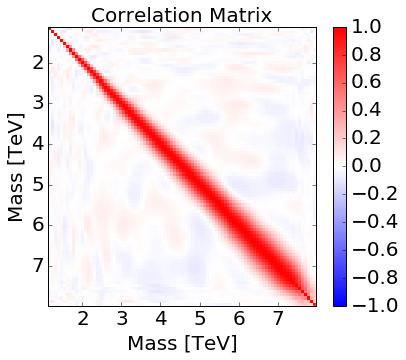

In [43]:
plot_cov(xvalO2D, corMat, covMat, False)
plot_cor(xvalO2D, corMat, False)

In [ ]:
plot_individualCov(corMat, covMat)

In [63]:
def func(x, A, B):
    return A*x+B

[  0.01711939  13.60915303]


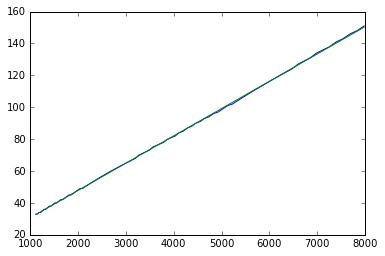

In [68]:
popt, pcov = op.curve_fit(func, xvalO, xerrO)
print popt
plt.plot(xvalO, xerrO)
plt.plot(xvalO, popt[0]*xvalO+popt[1])

In [225]:
from george.modeling import ModelingMixin
class PolynomialModel(ModelingMixin):
    parameter_names = ("p0", "p1", "p2")

    def get_value(self, t):
        t = t.flatten()
        return (self.p0 * (1.-t/13000.)**self.p1 * (t/13000.)**(self.p2))*xerr

In [226]:
Amp, decay, length, power, sub, p0, p1, p2 = [10., 150., 0.1, 10., 50., 1., 5., -8.]
kernel = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d = sub)
gp = george.GP(kernel, mean = PolynomialModel(p0=p0, p1=p1, p2=p2), fit_mean = True)


def lnlike1(p, t, y, terr):
    gp.set_vector(p)
    try:
        gp.compute(t, np.sqrt(y))
        return -gp.lnlikelihood(y)
    except:
        return np.inf

def lnprior1(p):
    Amp, Decay, Length, Power, Sub, p0, p1, p2 = p
    if (10 < Amp < 1000 and  1 < Decay < 200 and 0 < Length < 100 and 1 < Power < 100 and 1 < Sub < 100
        and 0.009 < p0 < 0.02 and 7.5 < p1 < 9 and -5.5 < p2 < -4.5):
        return 0.0
    return -np.inf

            
def lnprob1(p, x, y, xe):
    lp = lnprior2(p)
    return lp + lnlike2(p, x, y, xe) if np.isfinite(lp) else -np.inf

In [227]:
initial = [10., 150., 0.1, 10., 50., 0.01, 8., -5.]
print initial
ndim, nwalkers = len(initial), 32
data = (xval, yval, xerr)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob1, args = data)

print("Running first burn-in...")
p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 2000)

print("Running second burn-in...")
p0 = p0[np.argmax(lp)] + 1e-8 * np.random.randn(nwalkers, ndim)
sampler.reset()
p0, _, _ = sampler.run_mcmc(p0, 1000)
sampler.reset()

print("Running production...")
sampler.run_mcmc(p0, 1000);

[10.0, 150.0, 0.1, 10.0, 50.0, 0.01, 8.0, -5.0]
Running first burn-in...
Running second burn-in...
Running production...


[  1.99834088e+01   1.94192853e+02   4.05293634e+01   2.91551020e+01
   5.05875755e+00   9.19014107e-03   7.65713983e+00  -4.67851619e+00]


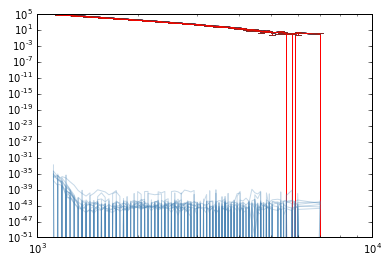

In [228]:
samples = sampler.flatchain
print samples[-11]
for s in samples[np.random.randint(len(samples), size=24)]:
    # Set up the GP for this sample.
    gp.set_vector(s)
    gp.compute(xval, np.sqrt(yval))

    # Compute the prediction conditioned on the observations and plot it.
    m = gp.sample_conditional(yval, xval)
    plt.plot(xval, m, color="#4682b4", alpha=0.3)
    plt.errorbar(xval, yval, yerr = np.sqrt(yval))
    plt.yscale('log')
    plt.xscale('log')

In [229]:
Amp, decay, length, power, sub, p0, p1, p2 = [10., 150., 0.1, 10., 50., 1., 5., -8.]
kernel = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d = sub)
gp = george.GP(kernel)
def model2(params, t, terr):
    _, _, _, _, _, p0, p1, p2 = params
    sqrts = 13000.
    return (p0 * (1.-t/sqrts)**p1 * (t/sqrts)**(p2))*terr

def lnlike2(p, t, y, terr):
    gp.set_vector(p[:5])
    try:
        gp.compute(t, np.sqrt(y))
        return -gp.lnlikelihood(y - model2(p, t, terr))
    except:
        return np.inf

def lnprior2(p):
    Amp, Decay, Length, Power, Sub, p0, p1, p2 = p
    if (10 < Amp < 1000 and  1 < Decay < 200 and 0 < Length < 100 and 1 < Power < 100 and 1 < Sub < 100
        and 0.009 < p0 < 0.02 and 7.5 < p1 < 9 and -5.5 < p2 < -4.5):
        return 0.0
    return -np.inf

            
def lnprob2(p, x, y, xe):
    lp = lnprior2(p)
    return lp + lnlike2(p, x, y, xe) if np.isfinite(lp) else -np.inf

In [230]:
initial = [10., 150., 0.1, 10., 50., 0.01, 8., -5.]
print initial
ndim, nwalkers = len(initial), 32
data = (xval, yval, xerr)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob2, args = data)

print("Running first burn-in...")
p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 2000)

print("Running second burn-in...")
p0 = p0[np.argmax(lp)] + 1e-8 * np.random.randn(nwalkers, ndim)
sampler.reset()
p0, _, _ = sampler.run_mcmc(p0, 1000)
sampler.reset()

print("Running production...")
sampler.run_mcmc(p0, 1000);

[10.0, 150.0, 0.1, 10.0, 50.0, 0.01, 8.0, -5.0]
Running first burn-in...
Running second burn-in...
Running production...


[  1.10135930e+01   8.41584390e+01   1.29401546e+00   1.71598920e+01
   1.52504904e+01   9.00074126e-03   8.99983128e+00  -4.50001735e+00]


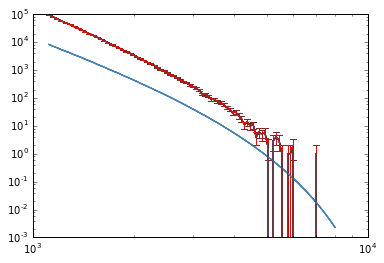

In [232]:
samples = sampler.flatchain
print samples[-11]
for s in samples[np.random.randint(len(samples), size=24)]:
    # Set up the GP for this sample.

    gp.set_vector(s[:5])
    gp.compute(xval, np.sqrt(yval))

    # Compute the prediction conditioned on the observations and plot it.
    m = gp.sample_conditional(yval - model2(s, xval, xerr), xvalO) + model2(s, xvalO, xerrO)
    plt.plot(xvalO, m, color="#4682b4", alpha=0.3)
    plt.errorbar(xvalO, yvalO, yerr = np.sqrt(yvalO))
    plt.yscale('log')
    plt.xscale('log')